In [ ]:
# Import the needed Packages
# FMU Simulation
import MoBASimulator as mb
# Numpy
import numpy as np
# Bokeh for Plotting
import bokeh.plotting as bk
import bokeh.io as bi
#from bokeh.io import export_svgs
#bi.output_notebook()
# Algorithms
import Algorithms as alg


# Model Parameter
k = [[10.,.5],[5.,8.]]
l = [[1e-10,1e-10],[1e-10,1e-10]]
# Generate stable polynomial with roots between -1....-1/20 rad/s for denominator
r = np.random.uniform(-1.0,-8.,(2,2,8))
p = np.zeros((2,2,9))
# Generate zeros between -1 and 1 for numerator
m = np.random.uniform(-1., 1., (2,2,8))
z = np.zeros((2,2,9))

for outputs in range(0,2):
    for inputs in range(0,2):
        p[outputs,inputs,:] = np.polynomial.polynomial.polyfromroots(r[outputs,inputs,:])
        z[outputs,inputs,:] = np.polynomial.polynomial.polyfromroots(m[outputs,inputs,:])
       
# The needed Parameter
K = np.zeros((2,2))
T = np.zeros((2,2))
L = np.zeros((2,2))

In [ ]:
# Load a Model
sim = mb.Simulator()
sim.clear()
sim.loadModel("C:/Users/juliu/Documents/Thesis/Modelica/FMU/2_2_n9/Masterthesis_Models_mimo_0processmodel.fmu")
sim.setOperationMode('FMU for ModelExchange')

# Show log window
sim.showLogWindow()


# Parameter Values
params = {}
# Loop over system size
for outputs in range(1,3):
    for inputs in range(1,3):
        # Process Parameter 
        # System Lag
        for order in range(0,9):
            params.update({"fmu.den["+str(outputs)+","+str(inputs)+","+str(order+1)+"]": p[outputs-1][inputs-1][order]})
            # System Gain
        params.update({"fmu.num["+str(outputs)+","+str(inputs)+",1]": k[outputs-1][inputs-1]})
        #params.update({"fmu.num["+str(outputs)+","+str(inputs)+","+str(order+1)+"]": k[outputs-1][inputs-1]*z[outputs-1][inputs-1][order]})
        # System Delay
        params.update({"fmu.delay["+str(outputs)+","+str(inputs)+"]": l[outputs-1][inputs-1]})

# Set Parameter and show for checking
sim.set(params)
sim.showParameterDialog()
# Get the state space representation
ss = sim.analyser_getStateSpaceForm()

# Identify

# First run, Input 1 -> Output 1 & 2
sim.set({"fmu.u[1]": 1,"fmu.u[2]": 0})
# Set timestep = 1e-2, endtime = 100
res=sim.simulate(0.01, 500)

# Get the signals
y = res["fmu.y[1]"]
y2 = res["fmu.y[2]"]
u = res["fmu.u[1]"]
time = res["time"]

# Get TF from Input 1 to Output 1
K[0][0],T[0][0],L[0][0]=alg.Integral_Identification(y,u,time)
# Get TF from Input 1 to Output 2
K[1][0],T[1][0],L[1][0]=alg.Integral_Identification(y2,u,time)


# Second run, Input 2 -> Output 1 & 2
# Reload the Model to set everything to zero
sim.resetModelState()
sim.set({"fmu.u[1]":0, "fmu.u[2]":1})
# Set timestep = 1e-2, endtime = 100
res=sim.simulate(0.01, 500)

# Get the signals
y = res["fmu.y[1]"]
y2 = res["fmu.y[2]"]
u = res["fmu.u[2]"]
time = res["time"]

# Get TF from Input 2 to Output 1
K[0][1],T[0][1],L[0][1] = alg.Integral_Identification(y,u,time)
# Get TF from Input 2 to Output 2
K[1][1],T[1][1],L[1][1] = alg.Integral_Identification(y2,u,time)
K,T,L

In [ ]:
# Make a controller
#KY,B,D = alg.Control_Decentral(K,T,L)
#KY,B,D = alg.Control_Astrom(K,T,L,0.01*np.eye(2,2))
KY,B,D = alg.Control_Decoupled(K,T,L,0.01*np.eye(2,2))

In [ ]:
# Make KPR,KPY, KIR and KIY
KPR = np.zeros((2,2))
KPY = np.zeros((2,2))
KIR = np.zeros((2,2))
KIY = np.zeros((2,2))
# Fill with values
for outputs in range(0,2):
    for inputs in range(0,2):
        # Proportional Controller
        KPY[outputs,inputs] = KY[outputs,inputs,0]
        # Intergral Controller
        KIY[outputs,inputs] = KY[outputs,inputs,1]

# Implement Set-point Weight
KPR = np.dot(B,KPY)
KIR = KIY

In [ ]:
# Store the Matrices
A = ss['A']
B = ss['B']
C = ss['C']
DSys = ss['D'] # Name different since decoupler D
I = np.eye(A.shape[0])
# Array for singular values
sv = np.zeros((2,1000))
counter = 0

# Frequency Spectrum
omega = np.logspace(-3,2,1e4)
# Singular Value Storage for sensitivity
sv_s = np.zeros((2,omega.shape[0]))
# Singular Value Storage for complementary sensitivity
sv_t = np.zeros((2,omega.shape[0]))

# Counter for storage
counter = 0
for freq in omega:
    G = np.dot(np.dot(C,np.linalg.inv(freq*1j*I-A)),B)+DSys
    S = np.linalg.inv(np.eye(2,2)-np.dot(G,np.add(KPY,1/(freq*1j)*KIY)))
    u,sv_s[:,counter],w = np.linalg.svd(np.abs(S))
    T = np.dot(S,np.dot(G, np.add(KPR,1/(freq*1j)*KIR) ))
    u,sv_t[:,counter],w = np.linalg.svd(np.abs(T))
    counter = counter +1


# Make Transfer function Matrix for frequency
p = bk.figure(title = "Singular values - Sensitivity Transfer Function", y_axis_type = "log",  x_axis_type = "log")
p.line(omega,sv_s[0,:], color = "blue")
p.line(omega,sv_s[1,:], color = "red")
bk.show(p)

p = bk.figure(title = "Singular values - Complementary Sensitivity Transfer Function", y_axis_type = "log",  x_axis_type = "log")
p.line(omega,sv_t[0,:], color = "blue")
p.line(omega,sv_t[1,:], color = "red")
bk.show(p)

[ 0.78090377  0.73939956  0.83696655  0.31338009  0.77566865]
[ 0.31338009  0.73939956  0.77566865  0.78090377  0.83696655]
[  9.09318389  21.45476504  22.50716604  22.65907052  24.28581452]
[  1.00000000e+00   2.86321206e-01   3.10481059e-02   1.62378836e-03
   4.13851643e-05   4.13851643e-07]
[-0.10997248 -0.04660969 -0.04443029 -0.04413244 -0.0411763 ]


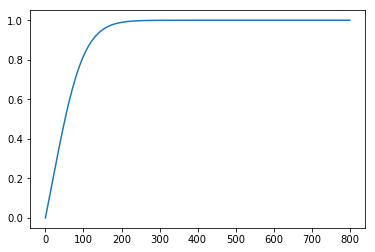

In [87]:
## Get the polynomial for varying degree
import numpy as np

# Make Sample, Output, Input, Order-1
den = np.random.uniform(0.1,1,(5))
print(den)
# Get the distance
dist = np.sort(den)
print(dist)
dist =100.*dist/np.sum(dist)
print(dist)
den = np.polynomial.polynomial.polyfromroots(-1. /dist)
den = den[::-1]
print(den)
print(np.roots(den))
import control as cn
tf = cn.tf(den[:-1]/100.,den)
y, t = cn.matlab.step(tf, T=np.linspace(0,800,1500))

import pylab as p
% matplotlib inline

p.plot(t,y)

In [52]:
# Make a Polynomial of degree 2
p = np.polynomial.polynomial.polyfromroots(den[0,0,0,:2])
p

IndexError: too many indices for array

In [ ]:
# Store the polynomial in numpy array
den = np.zeros((1,2,2,4))
#den[0,0,0,:] = np.array([1,2,3,4])
den[0,0,0,-3:] = p
den

In [ ]:
# Compute with a loop
sample_size = 1
inputs_n = 2
outputs_n = 2
max_order = 4
# Compute the roots
p =  np.random.uniform(0.1,1,(sample_size,inputs_n,outputs_n,max_order-1))
den = np.zeros((sample_size,inputs_n,outputs_n,max_order))
for samples in range(0,sample_size):
    for inputs in range(0,inputs_n):
        for outputs in range(0,outputs_n):
            den[samples, inputs, outputs,-max_order:] = np.polynomial.polynomial.polyfromroots(p[samples, inputs, outputs, :])
            

In [ ]:
den

In [ ]:
# Implement variable order
sample_size = 12
inputs_n = 2
outputs_n = 2
max_order = 4
# Compute the roots
p =  np.random.uniform(0.1,1,(sample_size,inputs_n,outputs_n,max_order))
den = np.zeros((sample_size,inputs_n,outputs_n,max_order+1))
for samples in range(0,sample_size):
    order = int(1.0*samples/sample_size * max_order)+1
    print(order)
    for inputs in range(0,inputs_n):
        for outputs in range(0,outputs_n):
            den[samples, inputs, outputs,-(order+1):] = np.polynomial.polynomial.polyfromroots(p[samples, inputs, outputs, :order])

In [ ]:
den